Here I select 8 tropical orographic regions. For each region, I plot a cross-section of the mountain height perpendicular to the range; as well as a similar cross-section of the mean precip for the rainiest month of the year. The angle defining the orientation of each mountain range was chosen manually.

In [48]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import time
import cartopy.crs as ccrs
import cartopy


In [49]:
orogm=xr.open_dataarray("../../data/ERA5orography.nc").isel(time=0)/9.81

In [50]:
trmmpr=xr.open_dataarray("../../data/TRMM.mnth.pr.20100101-20191231.nc")
trmmpr.coords['longitude'] = trmmpr.coords['longitude'] % 360
trmmpr = trmmpr.sortby(trmmpr.longitude)
trmmpr = trmmpr.reindex(latitude=list(reversed(trmmpr.latitude)))

In [51]:
era5pr=xr.open_dataarray("../../data/ERA5.mnth.tp.20100101-20191231.nc")
era5cape=xr.open_dataarray("../../data/ERA5.mnth.cape.20100101-20191231.nc")

In [84]:
#mountains=[([106,110,10,18],"Annamite range (Vietnam)",60),
#           ([73,78,9,17],"Western Ghats",70),
#           ([360-79,360-68,-17,-9],"Central Andes",45),
#           ([80,90,25,35],"Himalaya",10),
#           ([95,106,-6,6],"Bukit Barisan (Sumatra)",45),
#           ([135,150,-11,-1],"New Guinea highlands",10)
#          ]

mountains=[([102,113,10,18],"Annamite range (Vietnam)",60+180,11),
           ([70,80,9,17],"Western Ghats",70,7),
           ([95,106,-6,6],"Bukit Barisan (Sumatra)",45,11),
           ([77,82,5,9],"Sri Lanka",60+180,10),
           ([95,105,0,8],"Malaysia",45+180,11),
           ([135,150,-11,-1],"New Guinea highlands",10,3),
           ([360-82,360-68,-17,-9],"Central Andes",45+180,2),
           ([80,90,25,35],"Himalaya",10,7)
          ]

In [85]:
trmmpr_seasmean=[]
era5pr_seasmean=[]
for i,(lonlat,name,_,_) in enumerate(mountains):
    trmmpr_seasmean.append(trmmpr.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).groupby("time.month").mean(["time","latitude","longitude"]))
    era5pr_seasmean.append(era5pr.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).groupby("time.month").mean(["time","latitude","longitude"]))


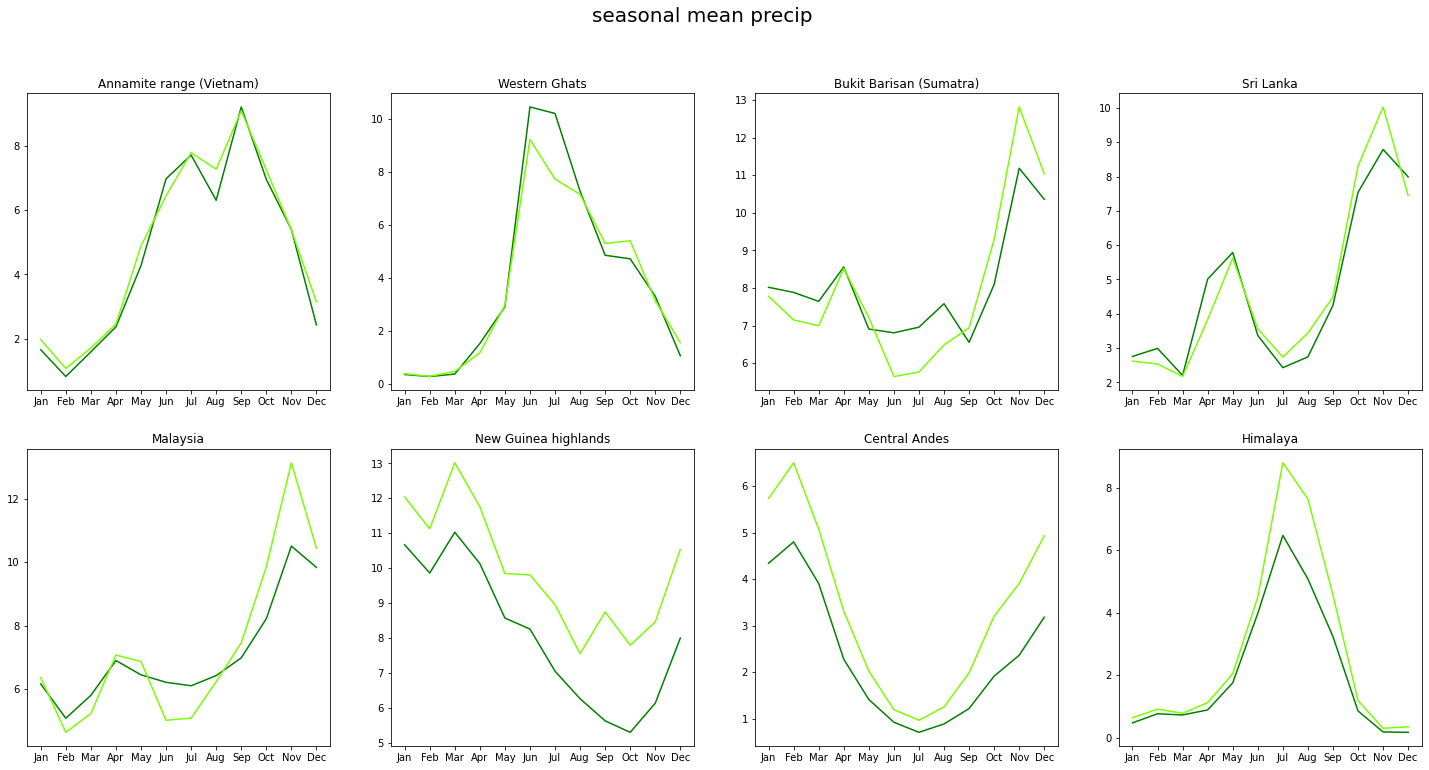

In [86]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)
mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,(lonlat,name,_,_) in enumerate(mountains):
    ax[i].set_title(name)
    ax[i].plot(mnths,2.8/1.9*24*trmmpr_seasmean[i],color='green',label="TRMM pr")
    ax[i].plot(mnths,1e3*era5pr_seasmean[i],color='lawngreen',label="ERA5 pr")
    
fig.suptitle("seasonal mean precip",fontsize=20);None

In [87]:
def mean_rotate(var,regions):
    """Computes rotated means of a given variable for all regions"""
    rotvars=[]
    for i,(lonlat,name,angle,mnth) in enumerate(regions):
        window=var.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
        if "time" in var.dims:
            window=window.groupby("time.month").mean("time").sel(month=mnth)
        rotvars.append(rotate(np.array(window)[::-1],90-angle,reshape=False,cval=np.nan))
    return rotvars

r_trmmpr   = mean_rotate(2.8/1.9*24*trmmpr  ,mountains)
r_orogm    = mean_rotate(orogm   ,mountains)
r_era5pr   = mean_rotate(1000*era5pr  ,mountains)
r_era5cape = mean_rotate(era5cape,mountains)

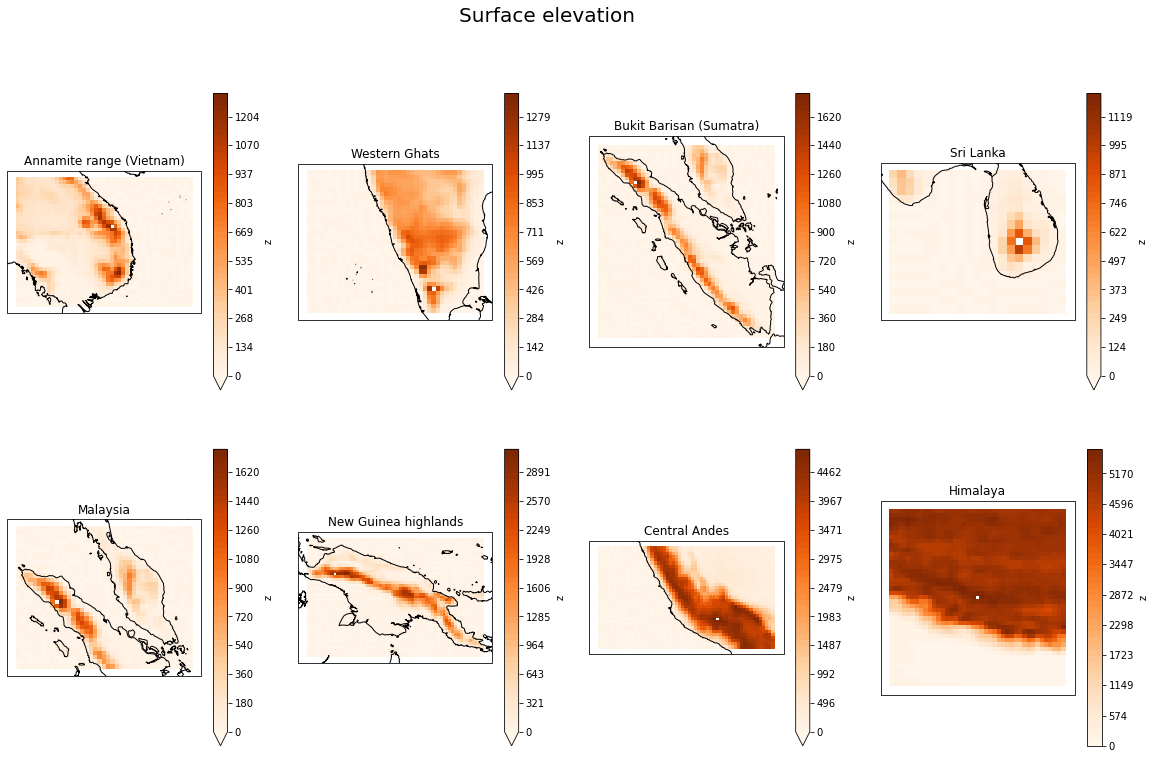

In [88]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
for i,(lonlat,name,_,_) in enumerate(mountains):
    ax[i].coastlines()
    window=orogm.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
    window.plot(ax=ax[i],transform=ccrs.PlateCarree(),cmap=plt.cm.Oranges,levels=np.linspace(0,window.max()))
    ax[i].set_title(name)
fig.suptitle("Surface elevation",fontsize=20);None

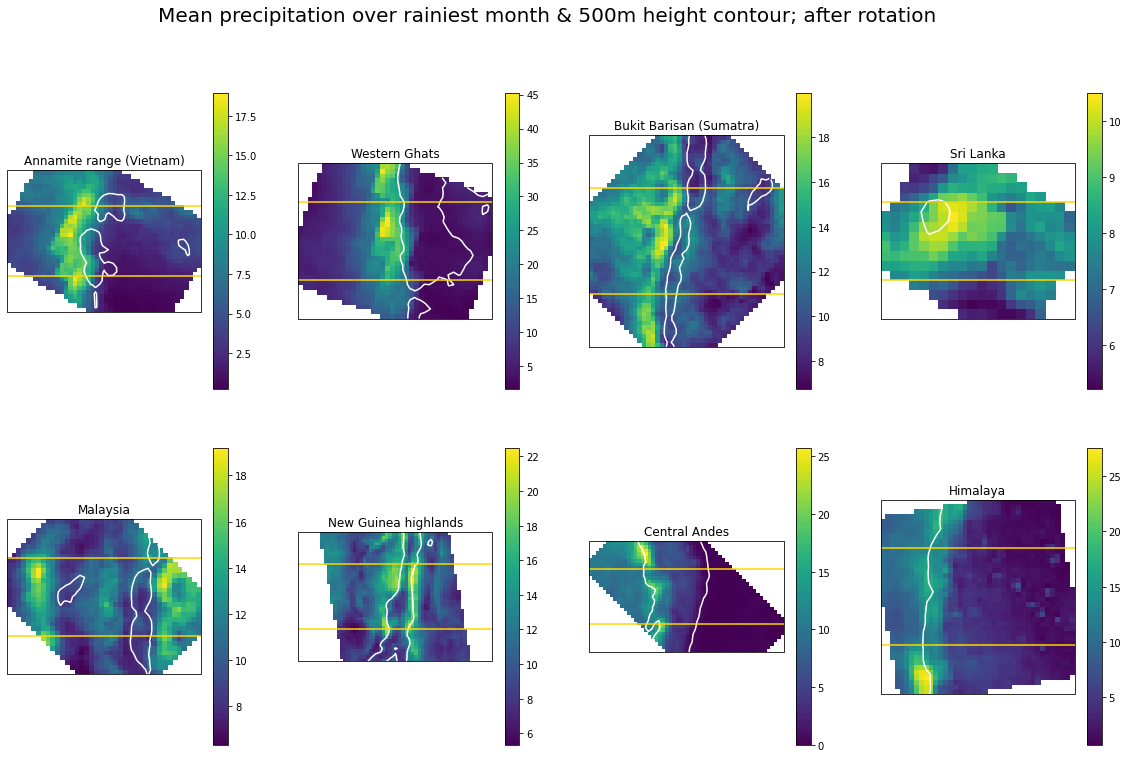

In [89]:
fig,ax = plt.subplots(2,4,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
for i,(_,name,_,_) in enumerate(mountains):
    im=ax[i].pcolormesh(r_trmmpr[i],cmap=plt.cm.viridis)
    ax[i].contour(r_orogm[i],**{'levels':[500],'colors':['w']})
    ax[i].set_title(name)
    n=len(r_orogm[i])
    ax[i].axhline(n//4,color="gold")
    ax[i].axhline(3*n//4,color="gold")
    fig.colorbar(im, ax=ax[i])
    
fig.suptitle("Mean precipitation over rainiest month & 500m height contour; after rotation",fontsize=20);None

/Users/quentin.nicolas/miniconda3/envs/atmos/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/quentin.nicolas/miniconda3/envs/atmos/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/quentin.nicolas/miniconda3/envs/atmos/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Users/quentin.nicolas/miniconda3/envs/atmos/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


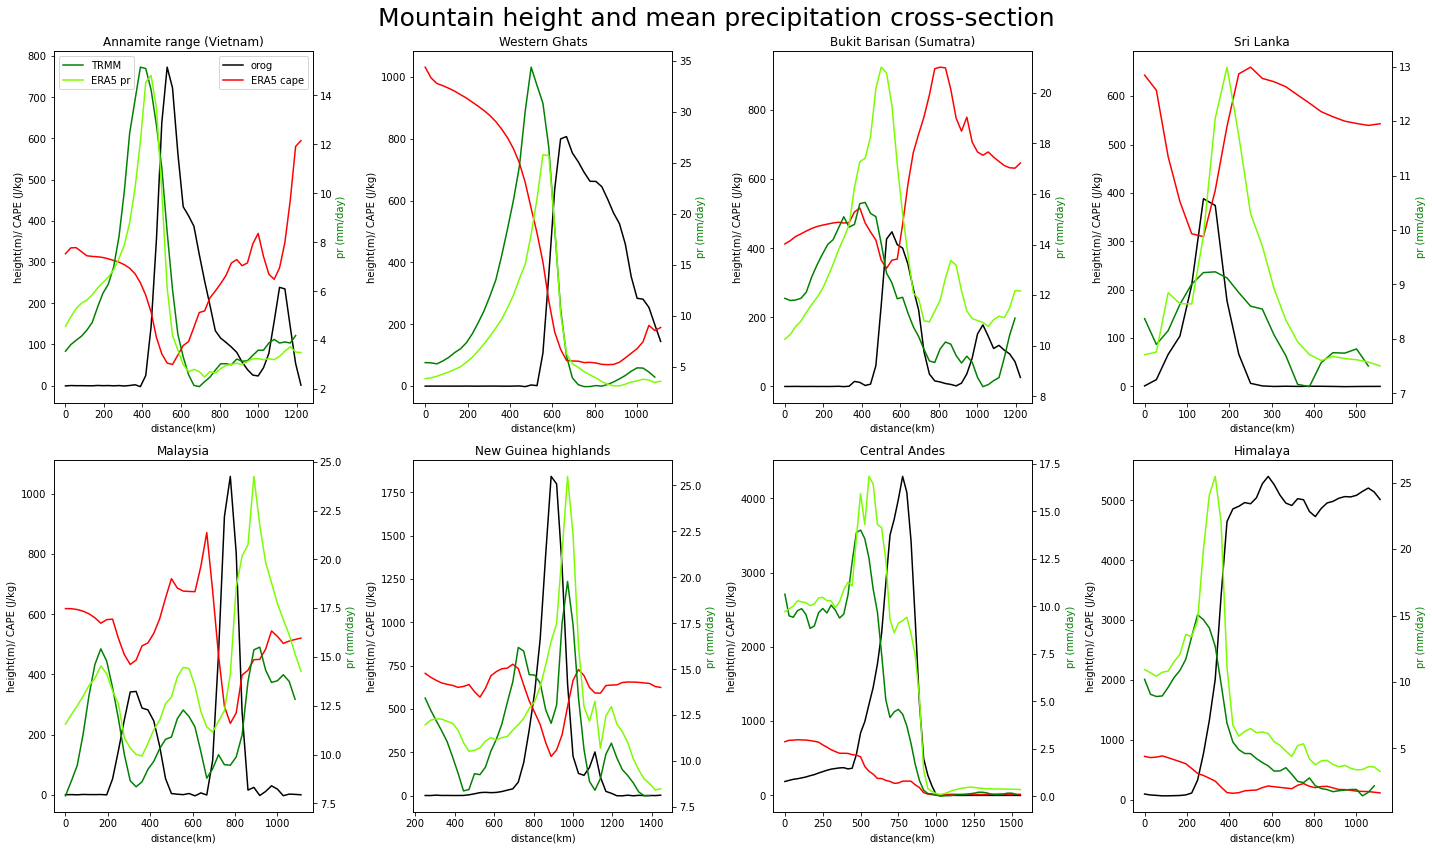

In [90]:
km_per_degreelat = 6370*np.pi/180
fig,ax = plt.subplots(2,4,figsize=(20,12))
ax = ax.reshape(-1)
for i,(lonlat,name,angle,_) in enumerate(mountains):
    ax[i].set_title(name)

    n,m=r_orogm[i].shape
    #ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],r_orogm[i][n//2,:])
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_orogm[i][n//4:3*n//4,:],axis=0),color='k',label='orog')
    ax[i].set_xlabel("distance(km)")
    ax[i].set_ylabel("height(m)/ CAPE (J/kg)")

    ax2=ax[i].twinx()
    ax2.set_ylabel('pr (mm/day)', color='g')
    n,m=r_trmmpr[i].shape
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_trmmpr[i][n//4:3*n//4,:],axis=0),'g',label='TRMM')
    
    n,m=r_era5pr[i].shape
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_era5pr[i][n//4:3*n//4,:],axis=0),color='lawngreen',label='ERA5 pr')
    
    
    n,m=r_era5cape[i].shape
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_era5cape[i][n//4:3*n//4,:],axis=0),'r',label='ERA5 cape')

    if i == 0:
        ax[i].legend()
        ax2.legend(loc="upper left")
        
fig.suptitle("Mountain height and mean precipitation cross-section",fontsize=25)
fig.tight_layout()



/Users/quentin.nicolas/miniconda3/envs/atmos/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/quentin.nicolas/miniconda3/envs/atmos/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Users/quentin.nicolas/miniconda3/envs/atmos/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


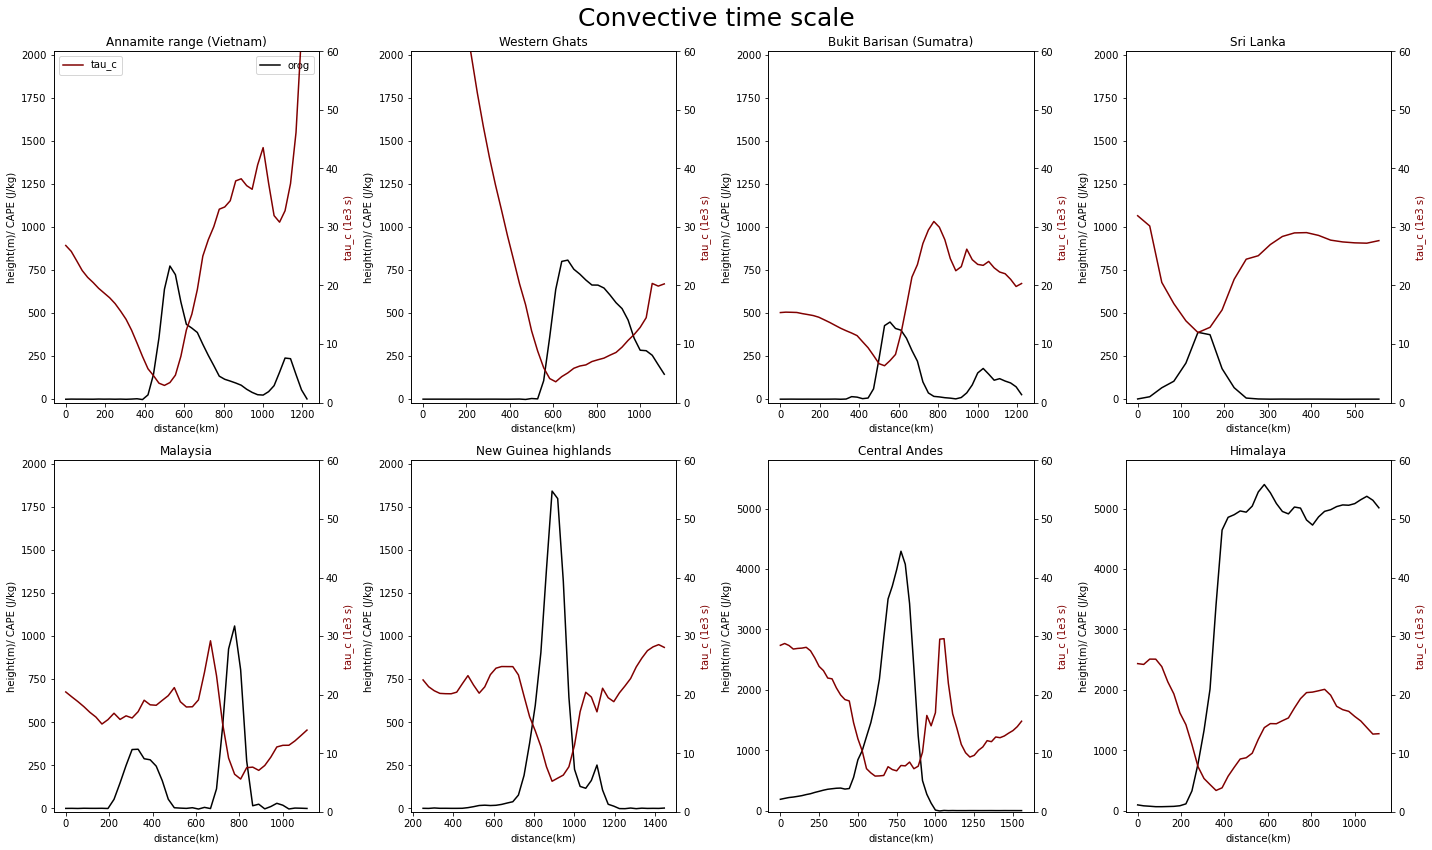

In [91]:
km_per_degreelat = 6370*np.pi/180
fig,ax = plt.subplots(2,4,figsize=(20,12))
ax = ax.reshape(-1)
for i,(lonlat,name,angle,_) in enumerate(mountains):
    ax[i].set_title(name)

    n,m=r_orogm[i].shape
    #ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],r_orogm[i][n//2,:])
    ax[i].plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],np.nanmean(r_orogm[i][n//4:3*n//4,:],axis=0),color='k',label='orog')
    ax[i].set_xlabel("distance(km)")
    ax[i].set_ylabel("height(m)/ CAPE (J/kg)")

    ax2=ax[i].twinx()
    ax2.set_ylabel('tau_c (1e3 s)', color='maroon')
    
    n,m=r_era5pr[i].shape
    pr = np.nanmean(r_era5pr[i][n//4:3*n//4,:],axis=0)
    cape = np.nanmean(r_era5cape[i][n//4:3*n//4,:],axis=0)
    ax2.plot(np.arange(0,10000,0.25*km_per_degreelat)[:m],86400*1e4*cape/pr/2.26e6 / 1000,color='maroon',label='tau_c')
    
    

    if i == 0:
        ax[i].legend()
        ax2.legend(loc="upper left")
    if i < 6:
        ax[i].set_ylim(-20,2020)
    else:
        ax[i].set_ylim(-20,5800)
    ax2.set_ylim(0,60)
    
fig.suptitle("Convective time scale",fontsize=25)
fig.tight_layout()

